In [1]:
#notebook heavily stolen from https://github.com/mirandabryson/WH-All-Hadronic-Coffea-Tools/blob/master/cutflownotebook.ipynb
import os
import time
import glob
import re
from functools import reduce

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import pandas as pd
import uproot_methods
import awkward


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def addRowToCutFlow(output, df, name, selection):
    '''
    add one row with name and selection for each process to the cutflow accumulator
    '''

    if selection is not None:
        output['cutflow'][name] += (sum(df['weight'][selection].flatten())*137)
    else:
        output['cutflow'][name] += (sum(df['weight'].flatten())*137)
            
def getCutFlowTable(output, outputname, lines = ['all']):
    '''
    Takes a cache and returns a formated cut-flow table of processes.
    Lines and processes have to follow the naming of the coffea processor output.
    '''
    res = pd.DataFrame([])
    for line in lines:
        res = res.append(pd.DataFrame({outputname : output['cutflow'][line]}, index=[line]))
    return res

In [40]:
# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

class WHhadProcessor(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

         # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset", "Primary dataset")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 40, 200, 1200)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, 0, 20)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'cutflow':              processor.defaultdict_accumulator(int),
            'number j':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass':               hist.Hist("Counts", dataset_axis, mass_axis),
            'ht':                   hist.Hist("Counts", dataset_axis, pt_axis),
            'met2':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'number j data':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b data':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h data':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w data':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj data':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met data':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass data':               hist.Hist("Counts", dataset_axis, mass_axis),
            
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        
        #Jagged Arrays
        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
         #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = ((fatjets.pt > 200))
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = ((fatjets.pt > 200) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #leptons
        
        one_e_cut = (electrons.pt > 20) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.2)
        one_e = electrons[one_e_cut]
        
        one_m_cut = (muons.pt > 20) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        one_m = muons[one_m_cut]
        
        one_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        one_t = taus[one_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
    
        #DPHI
        dphi_met_leadjs = abs((leadjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_leadjs = dphi_met_leadjs.argsort(ascending=True)
        min_dphi_met_leadjs = dphi_met_leadjs[sorted_dphi_met_leadjs==0]
        abs_min_dphi_met_leadjs = abs(min_dphi_met_leadjs)
        
        dphi_met_wmch = abs((leadWmcleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmch = dphi_met_wmch.argsort(ascending=True)
        min_dphi_met_wmch = dphi_met_wmch[sorted_dphi_met_wmch==0]
        abs_min_dphi_met_wmch = abs(min_dphi_met_wmch)
        
        dphi_met_wmdh = abs((leadWmdleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmdh = dphi_met_wmdh.argsort(ascending=True)
        min_dphi_met_wmdh = dphi_met_wmdh[sorted_dphi_met_wmdh==0]
        abs_min_dphi_met_wmdh = abs(min_dphi_met_wmdh)
        
        #softdrop mass
        hsd_cut = (htagged.softdrop > 1)
        hsd = htagged[hsd_cut]

        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 2)
        fatjet1_ps = (goodfatjets.counts >= 1)
        fatjet2_ps = (goodfatjets.counts >= 2)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        l_sel = (one_e.counts + one_m.counts + one_t.counts == 1)
        it_sel = (veto_it.counts == 0)
        mt_sel = (min_mt_b_met > 200).any()
        sd_sel = (hsd.count == 1)

        
        #cumulative preselection
        
        sel1 = l_sel
        sel3 = l_sel & met_ps
        sel4 = l_sel & met_ps & ht_ps
        sel5 = l_sel & met_ps & ht_ps & njet_ps 
        sel6 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel
        sel8 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet1_ps
        sel9 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel  & fatjet2_ps
        sel10 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet2_ps & h_sel 
        sel11 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps
        sel12 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps & sd_sel

        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 60

        #FILL OUTPUTS
        
        dataset = df["dataset"]
        output['number j'].fill(dataset=dataset, multiplicity = njets[sel9].flatten(), weight = wght)
        output['number b'].fill(dataset=dataset, multiplicity = numbjets[sel9].flatten(), weight = wght)
        output['number fj'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9].flatten(), weight = wght)
        output['number h'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9].flatten(), weight = wght)
        output['number w'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9].flatten(), weight = wght)
        output['met'].fill(dataset=dataset, pt = metpt[sel9].flatten(), weight = wght)
        output['h mass'].fill(dataset=dataset, mass = htagged.mass[sel9].flatten(), weight = wght)
        output['number j data'].fill(dataset=dataset, multiplicity = njets[sel9].flatten(), weight = 1)
        output['number b data'].fill(dataset=dataset, multiplicity = numbjets[sel9].flatten(), weight = 1)
        output['number fj data'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9].flatten(), weight = 1)
        output['number h data'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9].flatten(), weight = 1)
        output['number w data'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9].flatten(), weight = 1)
        output['met data'].fill(dataset=dataset, pt = metpt[sel9].flatten(), weight = 1)
        output['h mass data'].fill(dataset=dataset, mass = htagged.mass[sel9].flatten(), weight = 1)

        #raw cutflow
        
        addRowToCutFlow(output, df, 'all', None)
        addRowToCutFlow(output, df, '+ one lepton', sel1)
        addRowToCutFlow(output, df, '+ met', sel3)
        addRowToCutFlow(output, df, '+ ht', sel4)
        addRowToCutFlow(output, df, '+ njet', sel5)
        addRowToCutFlow(output, df, '+ bjet', sel6)
        addRowToCutFlow(output, df, '+ min(mt(bs,met))', sel7)
        addRowToCutFlow(output, df, '+ fatjet >=1 ', sel8)
        addRowToCutFlow(output, df, '+ fatjet >=2 ', sel9)
        #addRowToCutFlow(output, df, '+ h > 0', sel10)
        #addRowToCutFlow(output, df, '+ w(MC) > 0', sel11)

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [41]:
fileset_sig = {'mC750_had': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/*.root')}
fileset_wjets = {'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WJetsToLNu*/*.root')}
fileset_qcd = {'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/QCD_HT*/*.root')}
fileset_ttjets = {'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/TTJets*/*.root')}
fileset_znunu = {'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZJetsToNuNu*/*.root')}
fileset_st = {'ST':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ST*/*.root')}
fileset_ttwz = {'ttW/ttZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttWJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttZJets*/*.root')}
fileset_2b = {'2bosons':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WW*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WZ*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2L2Nu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2Q2Nu*/*.root')}
fileset_data = {'MET_Run': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p24/*/*.root')}

output_data = processor.run_uproot_job(fileset_data,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_wjets = processor.run_uproot_job(fileset_wjets,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 ) 
output_qcd = processor.run_uproot_job(fileset_qcd,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_ttjets = processor.run_uproot_job(fileset_ttjets,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_znunu = processor.run_uproot_job(fileset_znunu,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_st = processor.run_uproot_job(fileset_st,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_ttwz = processor.run_uproot_job(fileset_ttwz,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_2b = processor.run_uproot_job(fileset_2b,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=87.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=68.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=72.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=54.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=30.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=82.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=16.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=32.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python

In [42]:
getCutFlowTable(output_sig, 'mC750_had', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,mC750_had
all,297.956555
+ one lepton,13.569897
+ met,12.481872
+ ht,12.360230
+ njet,12.346714
+ bjet,4.642689
"+ min(mt(bs,met))",3.723612
+ fatjet >=1,3.588454
+ fatjet >=2,2.013859


In [43]:
getCutFlowTable(output_wjets, 'WJets', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,WJets
all,6.478594e+06
+ one lepton,1.172896e+06
+ met,5.266195e+05
+ ht,4.908394e+05
+ njet,4.855626e+05
+ bjet,5.864285e+03
"+ min(mt(bs,met))",1.924607e+03
+ fatjet >=1,1.877193e+03
+ fatjet >=2,6.454719e+02


In [44]:

getCutFlowTable(output_qcd, 'QCD', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,QCD
all,3.910187e+06
+ one lepton,8.246654e+05
+ met,4.614902e+05
+ ht,4.577765e+05
+ njet,4.551101e+05
+ bjet,1.316891e+04
"+ min(mt(bs,met))",6.128324e+03
+ fatjet >=1,1.093153e+03
+ fatjet >=2,5.699959e+02


In [45]:
getCutFlowTable(output_ttjets, 'TTJets', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,TTJets
all,928788.070357
+ one lepton,204196.480022
+ met,83395.976780
+ ht,80395.070238
+ njet,80370.549587
+ bjet,30325.082742
"+ min(mt(bs,met))",2872.843868
+ fatjet >=1,2575.562807
+ fatjet >=2,1059.595967


In [46]:
getCutFlowTable(output_znunu, 'ZNuNu', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ZNuNu
all,1.749745e+06
+ one lepton,5.088443e+04
+ met,2.330464e+04
+ ht,1.832652e+04
+ njet,1.799077e+04
+ bjet,3.612404e+02
"+ min(mt(bs,met))",1.819702e+02
+ fatjet >=1,1.515931e+02
+ fatjet >=2,3.491298e+01


In [47]:
getCutFlowTable(output_st, 'ST', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ST
all,291963.198720
+ one lepton,59165.221302
+ met,25687.361584
+ ht,24352.766763
+ njet,24315.752828
+ bjet,6570.168526
"+ min(mt(bs,met))",2376.535672
+ fatjet >=1,2097.382113
+ fatjet >=2,923.560995


In [48]:
getCutFlowTable(output_ttwz, 'ttW/ttZ', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ttW/ttZ
all,11906.833334
+ one lepton,2456.457086
+ met,1293.853977
+ ht,1263.411442
+ njet,1263.239325
+ bjet,536.680642
"+ min(mt(bs,met))",161.991696
+ fatjet >=1,139.418469
+ fatjet >=2,62.820634


In [49]:

getCutFlowTable(output_2b, '2bosons', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,2bosons
all,90495.015945
+ one lepton,13226.625874
+ met,6619.779284
+ ht,5898.045834
+ njet,5857.538127
+ bjet,97.107760
"+ min(mt(bs,met))",35.857692
+ fatjet >=1,32.958862
+ fatjet >=2,11.245095


/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 10000)

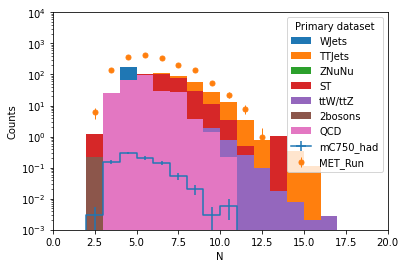

In [50]:
%matplotlib inline
ax = hist.plot1d(output_sig["number j"], density=False, stack=False)
hist.plot1d(output_wjets["number j"], density=False, stack=True)
hist.plot1d(output_ttjets["number j"], density=False, stack=True)
hist.plot1d(output_znunu["number j"], density=False, stack=True)
hist.plot1d(output_st["number j"], density=False, stack=True)
hist.plot1d(output_ttwz["number j"], density=False, stack=True)
hist.plot1d(output_2b["number j"], density=False, stack=True)
hist.plot1d(output_qcd["number j"], density=False, stack=True)
ax=hist.plot1d(output_data["number j data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,10000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 100000)

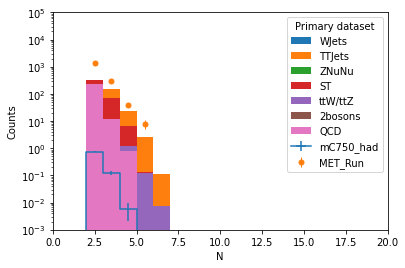

In [51]:
ax = hist.plot1d(output_sig["number b"], density=False)
hist.plot1d(output_wjets["number b"], density=False, stack=True)
hist.plot1d(output_ttjets["number b"], density=False, stack=True)
hist.plot1d(output_znunu["number b"], density=False, stack=True)
hist.plot1d(output_st["number b"], density=False, stack=True)
hist.plot1d(output_ttwz["number b"], density=False, stack=True)
hist.plot1d(output_2b["number b"], density=False, stack=True)
hist.plot1d(output_qcd["number b"], density=False, stack=True)
hist.plot1d(output_data["number b data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 100000)

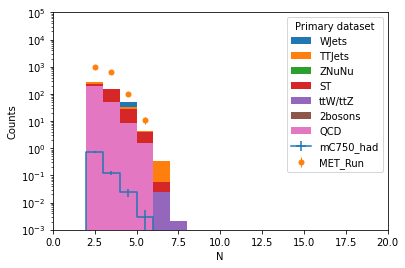

In [52]:
ax = hist.plot1d(output_sig["number fj"], density=False)
hist.plot1d(output_wjets["number fj"], density=False, stack=True)
hist.plot1d(output_ttjets["number fj"], density=False, stack=True)
hist.plot1d(output_znunu["number fj"], density=False, stack=True)
hist.plot1d(output_st["number fj"], density=False, stack=True)
hist.plot1d(output_ttwz["number fj"], density=False, stack=True)
hist.plot1d(output_2b["number fj"], density=False, stack=True)
hist.plot1d(output_qcd["number fj"], density=False, stack=True)
hist.plot1d(output_data["number fj data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 100000)

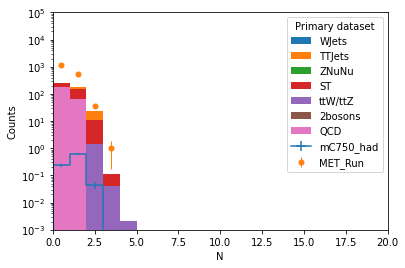

In [53]:
ax = hist.plot1d(output_sig["number h"], density=False)
hist.plot1d(output_wjets["number h"], density=False, stack=True)
hist.plot1d(output_ttjets["number h"], density=False, stack=True)
hist.plot1d(output_znunu["number h"], density=False, stack=True)
hist.plot1d(output_st["number h"], density=False, stack=True)
hist.plot1d(output_ttwz["number h"], density=False, stack=True)
hist.plot1d(output_2b["number h"], density=False, stack=True)
hist.plot1d(output_qcd["number h"], density=False, stack=True)
hist.plot1d(output_data["number h data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 100000)

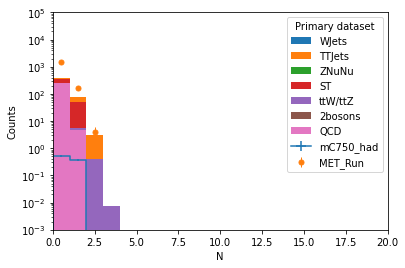

In [54]:
ax = hist.plot1d(output_sig["number w"], density=False)
hist.plot1d(output_wjets["number w"], density=False, stack=True)
hist.plot1d(output_ttjets["number w"], density=False, stack=True)
hist.plot1d(output_znunu["number w"], density=False, stack=True)
hist.plot1d(output_st["number w"], density=False, stack=True)
hist.plot1d(output_ttwz["number w"], density=False, stack=True)
hist.plot1d(output_2b["number w"], density=False, stack=True)
hist.plot1d(output_qcd["number w"], density=False, stack=True)
hist.plot1d(output_data["number w data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 100000)

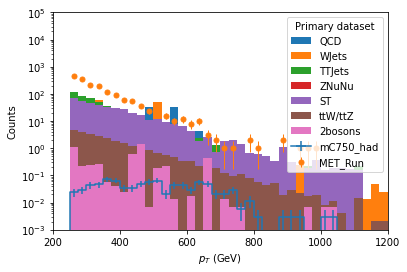

In [55]:
ax = hist.plot1d(output_qcd["met"], density=False, stack=True)
hist.plot1d(output_sig["met"], density=False)
hist.plot1d(output_wjets["met"], density=False, stack=True)
hist.plot1d(output_ttjets["met"], density=False, stack=True)
hist.plot1d(output_znunu["met"], density=False, stack=True)
hist.plot1d(output_st["met"], density=False, stack=True)
hist.plot1d(output_ttwz["met"], density=False, stack=True)
hist.plot1d(output_2b["met"], density=False, stack=True)
hist.plot1d(output_data["met data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

(0.001, 10000)

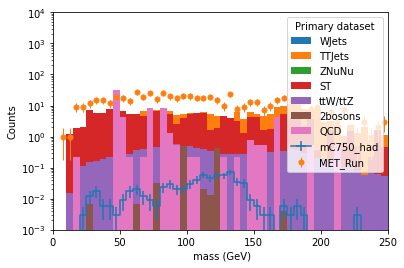

In [56]:
ax = hist.plot1d(output_sig["h mass"], density=False)
hist.plot1d(output_wjets["h mass"], density=False, stack=True)
hist.plot1d(output_ttjets["h mass"], density=False, stack=True)
hist.plot1d(output_znunu["h mass"], density=False, stack=True)
hist.plot1d(output_st["h mass"], density=False, stack=True)
hist.plot1d(output_ttwz["h mass"], density=False, stack=True)
hist.plot1d(output_2b["h mass"], density=False, stack=True)
hist.plot1d(output_qcd["h mass"], density=False, stack=True)
hist.plot1d(output_data["h mass data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,10000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.001, 1000000)

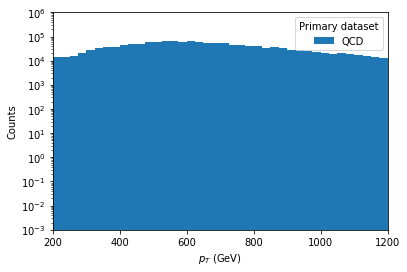

In [27]:
ax = hist.plot1d(output_qcd["ht"], density=False, stack=True)
ax.set_yscale('log')
ax.set_ylim(0.001,1000000)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.001, 10000000)

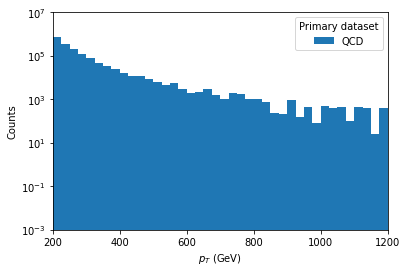

In [28]:
ax = hist.plot1d(output_qcd["met2"], density=False, stack=True)
ax.set_yscale('log')
ax.set_ylim(0.001,10000000)